# Bulk RNA-seq Conditional VAE

This notebook demonstrates training a conditional VAE on bulk RNA-seq data.

## Learning Objectives
1. Understand the cVAE architecture for gene expression
2. Train on synthetic data with tissue/disease/batch conditioning
3. Evaluate reconstruction and latent space quality
4. Generate counterfactual samples

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from genailab.data.loaders import ToyBulkDataset, split_dataset
from genailab.model.conditioning import ConditionSpec, ConditionEncoder
from genailab.model.vae import CVAE, elbo_loss
from genailab.workflows.train import train_cvae
from genailab.eval.counterfactual import counterfactual_decode
from genailab.utils.reproducibility import set_seed, get_device

In [2]:
# Set seed for reproducibility
set_seed(42)
device = get_device()
print(f"Using device: {device}")

Using device: mps


## 1. Create Synthetic Dataset

We use a toy dataset with:
- 5000 samples
- 2000 genes
- 6 tissues, 3 diseases, 10 batches

In [3]:
# Create dataset
ds = ToyBulkDataset(
    n=5000,
    n_genes=2000,
    n_tissues=6,
    n_diseases=3,
    n_batches=10,
    seed=42,
)

# Split into train/val
train_ds, val_ds = split_dataset(ds, val_frac=0.1)
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

Train: 4500, Val: 500


## 2. Build the Model

The cVAE has:
- **Condition Encoder**: Embeds categorical conditions (tissue, disease, batch)
- **Encoder**: Maps (x, c) → (μ, σ) for latent z
- **Decoder**: Maps (z, c) → x_hat

In [4]:
# Define condition specification
spec = ConditionSpec(
    n_cats={"tissue": ds.n_tissues, "disease": ds.n_diseases, "batch": ds.n_batches},
    emb_dim=32,
    out_dim=128,
)

# Create model
cond_enc = ConditionEncoder(spec)
model = CVAE(
    n_genes=ds.n_genes,
    z_dim=64,
    cond_encoder=cond_enc,
    hidden=512,
)
model.to(device)

# Count parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")

Model parameters: 2,835,376


## 3. Train the Model

In [5]:
# Train
history = train_cvae(
    model,
    train_loader,
    val_loader,
    device=str(device),
    epochs=30,
    lr=1e-3,
    beta=0.5,  # beta-VAE: weight on KL term
    outdir="runs/cvae_toy",
)

epoch 001 | train loss=0.8684 recon=0.8440 kl=0.0488 | val loss=0.7531
epoch 002 | train loss=0.7172 recon=0.6383 kl=0.1577 | val loss=0.6747
epoch 003 | train loss=0.6659 recon=0.5731 kl=0.1856 | val loss=0.6385
epoch 004 | train loss=0.6265 recon=0.5251 kl=0.2028 | val loss=0.6072
epoch 005 | train loss=0.5926 recon=0.4825 kl=0.2203 | val loss=0.5779
epoch 006 | train loss=0.5694 recon=0.4537 kl=0.2314 | val loss=0.5510
epoch 007 | train loss=0.5475 recon=0.4274 kl=0.2403 | val loss=0.5335
epoch 008 | train loss=0.5327 recon=0.4118 kl=0.2418 | val loss=0.5220
epoch 009 | train loss=0.5173 recon=0.3935 kl=0.2475 | val loss=0.5043
epoch 010 | train loss=0.5083 recon=0.3807 kl=0.2554 | val loss=0.4987
epoch 011 | train loss=0.4951 recon=0.3627 kl=0.2648 | val loss=0.4827
epoch 012 | train loss=0.4873 recon=0.3503 kl=0.2740 | val loss=0.4730
epoch 013 | train loss=0.4786 recon=0.3378 kl=0.2815 | val loss=0.4704
epoch 014 | train loss=0.4672 recon=0.3219 kl=0.2905 | val loss=0.4533
epoch 

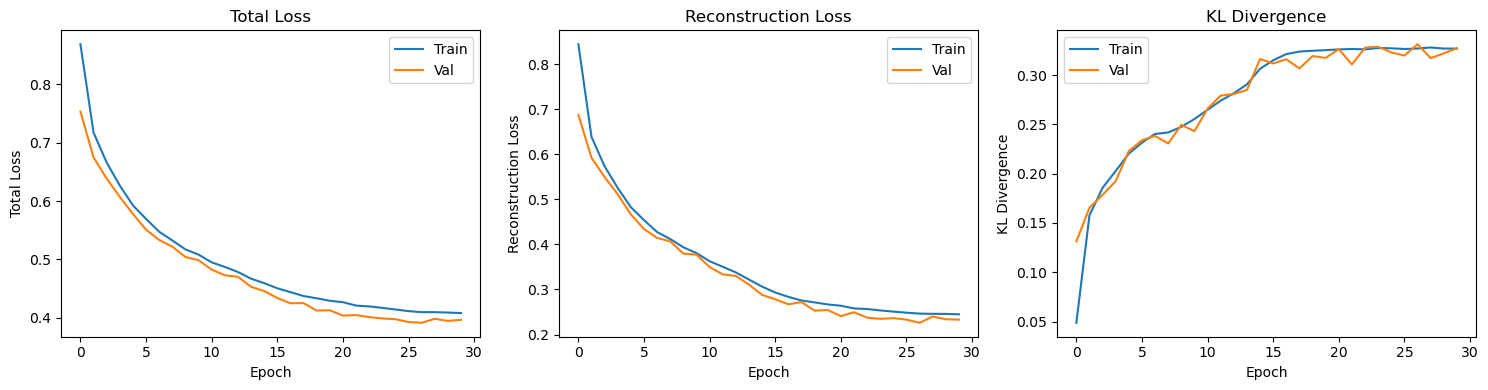

In [9]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].legend()
axes[0].set_title('Total Loss')

axes[1].plot(history['train_recon'], label='Train')
axes[1].plot(history['val_recon'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].legend()
axes[1].set_title('Reconstruction Loss')

axes[2].plot(history['train_kl'], label='Train')
axes[2].plot(history['val_kl'], label='Val')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('KL Divergence')
axes[2].legend()
axes[2].set_title('KL Divergence')

plt.tight_layout()
plt.show()

In [10]:
fig.savefig("../docs/VAE/figures/training_curves_healthy.png", dpi=150, bbox_inches="tight")

## 4. Evaluate Reconstruction

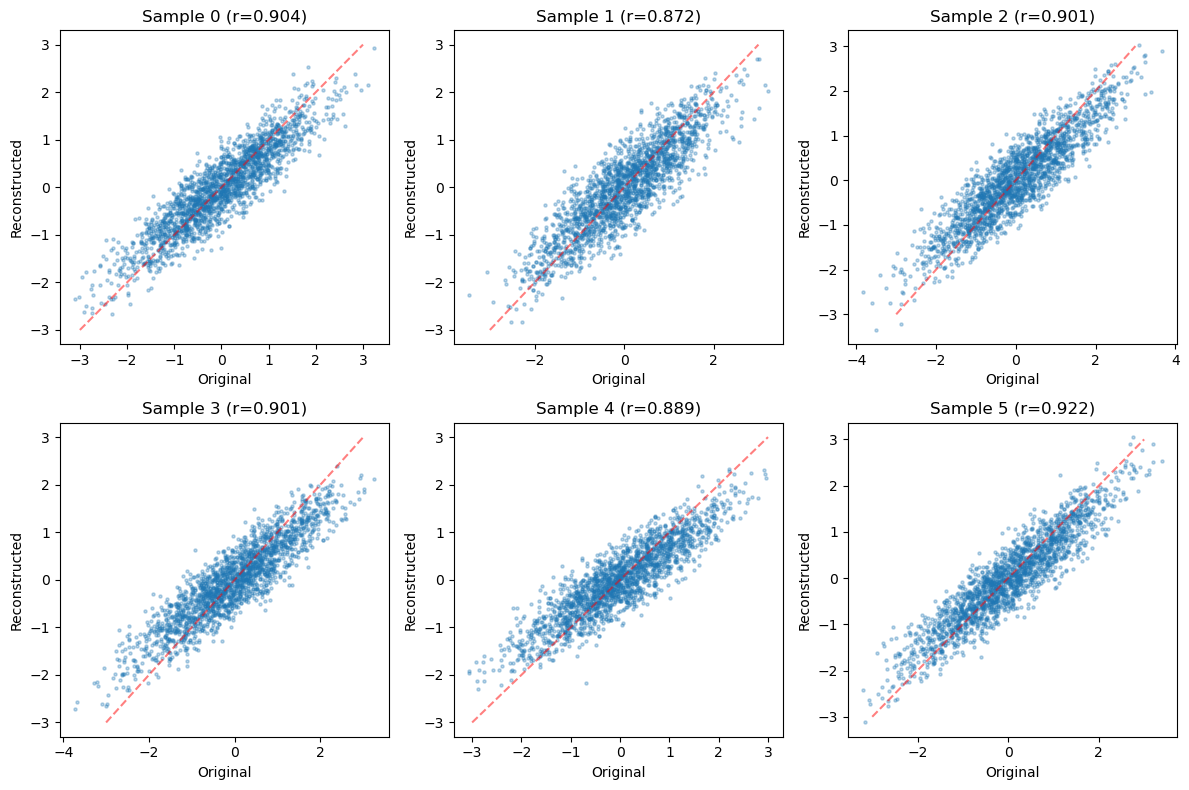

In [7]:
# Get a batch of validation data
model.eval()
batch = next(iter(val_loader))
x = batch['x'].to(device)
cond = {k: v.to(device) for k, v in batch['cond'].items()}

with torch.no_grad():
    out = model(x, cond)
    x_hat = out['x_hat']

# Plot reconstruction for a few samples
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.scatter(x[i].cpu(), x_hat[i].cpu(), alpha=0.3, s=5)
    ax.plot([-3, 3], [-3, 3], 'r--', alpha=0.5)
    corr = np.corrcoef(x[i].cpu(), x_hat[i].cpu())[0, 1]
    ax.set_title(f'Sample {i} (r={corr:.3f})')
    ax.set_xlabel('Original')
    ax.set_ylabel('Reconstructed')

plt.tight_layout()
plt.show()

## 5. Visualize Latent Space

In [ ]:
# Encode all validation data
all_z = []
all_tissue = []
all_disease = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        x = batch['x'].to(device)
        cond = {k: v.to(device) for k, v in batch['cond'].items()}
        mu, _ = model.encode(x, cond)
        all_z.append(mu.cpu().numpy())
        all_tissue.append(batch['cond']['tissue'].numpy())
        all_disease.append(batch['cond']['disease'].numpy())

z = np.concatenate(all_z)
tissue = np.concatenate(all_tissue)
disease = np.concatenate(all_disease)

In [ ]:
# PCA visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
z_2d = pca.fit_transform(z)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter1 = axes[0].scatter(z_2d[:, 0], z_2d[:, 1], c=tissue, cmap='tab10', alpha=0.5, s=10)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Latent Space (colored by Tissue)')
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(z_2d[:, 0], z_2d[:, 1], c=disease, cmap='tab10', alpha=0.5, s=10)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('Latent Space (colored by Disease)')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

## 6. Counterfactual Generation

The key capability: given a sample with condition c, generate what it would look like under condition c'.

In [ ]:
# Get samples with disease=0
batch = next(iter(val_loader))
mask = batch['cond']['disease'] == 0
x = batch['x'][mask][:10].to(device)
cond = {k: v[mask][:10].to(device) for k, v in batch['cond'].items()}

# Create counterfactual condition: disease 0 -> disease 1
cond_cf = {k: v.clone() for k, v in cond.items()}
cond_cf['disease'] = torch.ones_like(cond['disease'])

# Generate counterfactual
with torch.no_grad():
    x_cf = counterfactual_decode(model, x, cond, cond_cf)

# Analyze changes
x_np = x.cpu().numpy()
x_cf_np = x_cf.cpu().numpy()
mean_change = (x_cf_np - x_np).mean(axis=0)

# Plot top changed genes
top_idx = np.argsort(np.abs(mean_change))[-20:]

plt.figure(figsize=(12, 6))
colors = ['red' if c > 0 else 'blue' for c in mean_change[top_idx]]
plt.barh(range(20), mean_change[top_idx], color=colors, alpha=0.7)
plt.yticks(range(20), [f'gene_{i}' for i in top_idx])
plt.xlabel('Mean Expression Change')
plt.title('Top 20 Genes Affected by Disease 0 → 1 Counterfactual')
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## Summary

In this notebook, we:
1. Created a synthetic bulk RNA-seq dataset with tissue/disease/batch effects
2. Built and trained a conditional VAE
3. Evaluated reconstruction quality
4. Visualized the latent space
5. Generated counterfactual samples (disease intervention)

### Next Steps
- Try real data (GEO, TCGA)
- Evaluate DE agreement between real and generated contrasts
- Add batch adversarial training to reduce batch leakage
- Implement scRNA-seq version with Negative Binomial likelihood